In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost, time

from scipy import stats

from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid
from sklearn import metrics, ensemble

from sklearn.metrics import pairwise_distances, accuracy_score, f1_score
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.utils import resample

# Data Loading

In [2]:
root_directory = 'D:\Data_Science\Instacart'

In [3]:
test = pd.read_csv(root_directory + '\order_products__test_cap.csv')
train = pd.read_csv(root_directory + '\order_products__train_cap.csv')
prior = pd.read_csv(root_directory + '\order_products__prior.csv', 
                    dtype={'order_id': np.int32,
                           'product_id': np.uint16,
                           'add_to_cart_order': np.int16,
                           'reordered': np.int8})
orders = pd.read_csv(root_directory + '\orders.csv',
                    dtype={'order_id': np.int32,
                            'user_id': np.int64,
                            'eval_set': 'category',
                            'order_number': np.int16,
                            'order_dow': np.int8,
                            'order_hour_of_day': np.int8,
                            'days_since_prior_order': np.float32})
products = pd.read_csv(root_directory + '\products.csv')
departments = pd.read_csv(root_directory + '\departments.csv')
aisles = pd.read_csv(root_directory + '\\aisles.csv')

# Data Exploration

In [4]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

Let's start by checking for missing values. It seems like 200k days since prior order are missing, which makes sense since there are 200k unique user_id and their first purchase didn't have a previous one to compute that value with.

In [5]:
print(len(test.order_id.unique()))
print(len(train.order_id.unique()))

32803
98406


In [6]:
print(len(prior.order_id.unique()))

3214874


In [7]:
orders.groupby('eval_set').count()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,
prior,3214874,3214874,3214874,3214874,3214874,3008665
test,75000,75000,75000,75000,75000,75000
train,131209,131209,131209,131209,131209,131209


When checking for consistency in the data it seems that the Capgemini test and train files have been modified and do not correspond to the orders file's eval_set columns so we will rectify that to avoid further issue.

In [8]:
orders.isin(test.order_id.tolist()).order_id.sum() + orders.isin(train.order_id.tolist()).order_id.sum()

131209

In [9]:
### Dropping the test orders since they're not present in our test file
orders = orders.loc[orders['eval_set'] != "test"]

In [10]:
### Correcting the eval_set column with the right test orders
orders.loc[(orders.index[orders.isin(test.order_id.tolist()).order_id]), 'eval_set'] = 'test'

Let's take a look into the actual data now

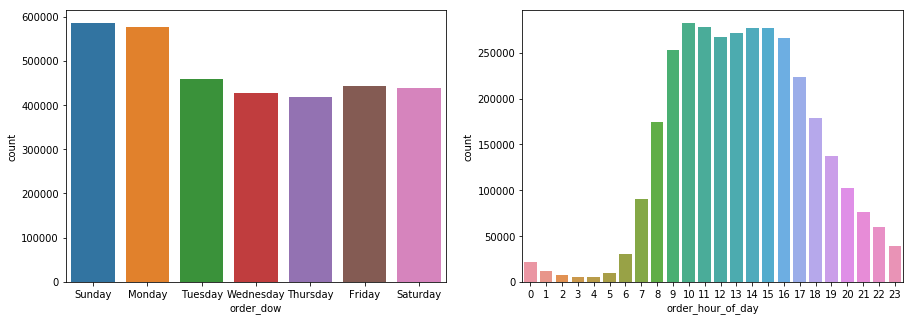

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(121)
g = sns.countplot(orders.order_dow)
g.set(xticklabels=['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']);
plt.subplot(122)
sns.countplot(orders.order_hour_of_day);

It seems like the most popular days for shopping are Sunday and Monday, and around 10/11am or 3/4pm.

In [12]:
prior = pd.merge(prior, orders, on='order_id', how='left')

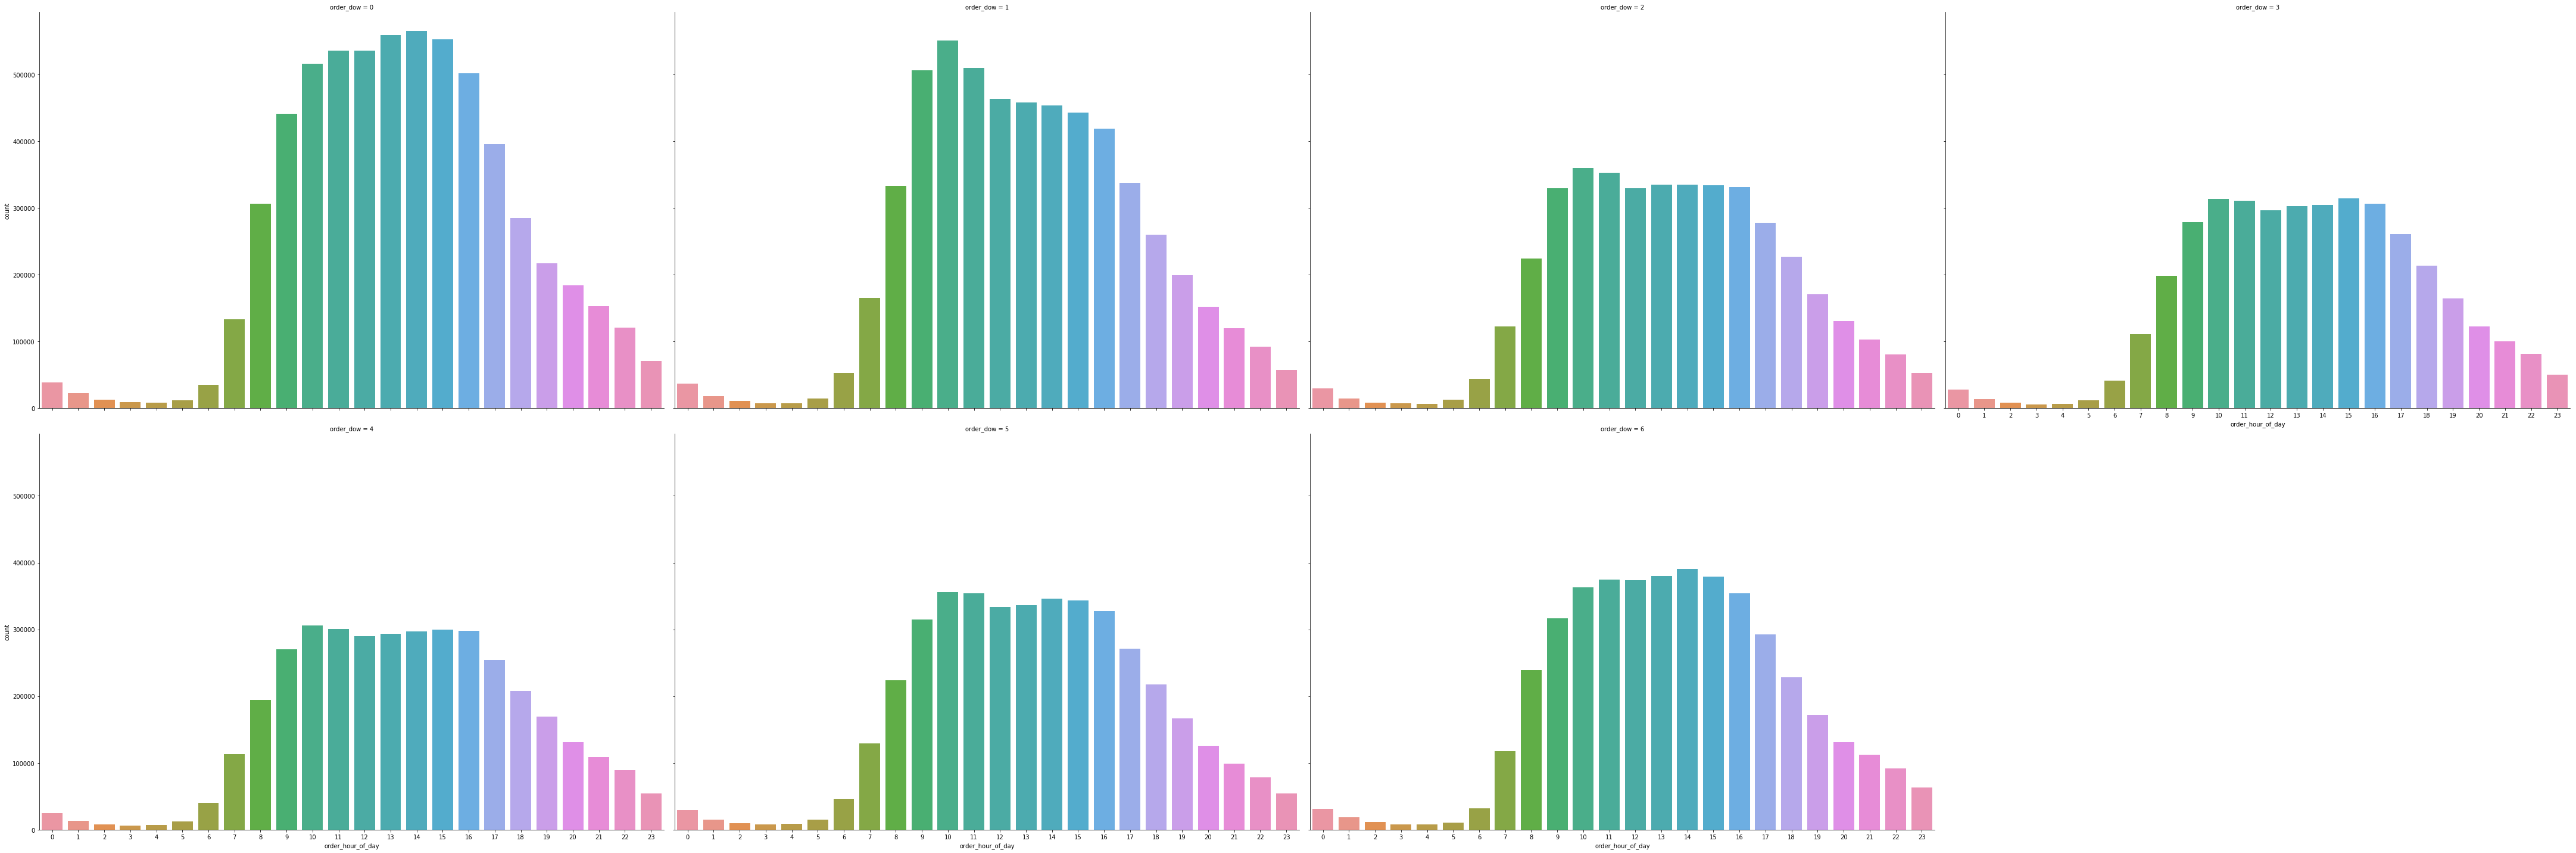

In [13]:
g = sns.catplot(x="order_hour_of_day" , col="order_dow", data=prior, kind="count", 
                height=10, aspect=1.5, col_wrap=4);
g.savefig("order_hour_day_count.png")
plt.show;

Different days show different trends though, On the weeeknd, users tend to shop later than during the week, monday mornings seem very popular for shopping.

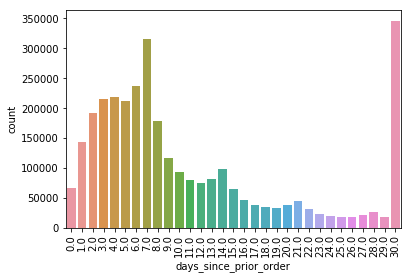

In [14]:
days_count = sns.countplot(orders.days_since_prior_order)
days_count.set_xticklabels(days_count.get_xticklabels(), rotation=90);

Most people shop regularly, coming back in less than 10 days. Some customers however are very sporadic buyers and spend more than 30 days between orders (every order past 30 days is counted as being 30 days after the previous one).

In [15]:
prior = pd.merge(prior, products, on='product_id', how='left')
prior = pd.merge(prior, departments, on='department_id', how='left')
prior = pd.merge(prior, aisles, on='aisle_id', how='left')
del departments
del aisles

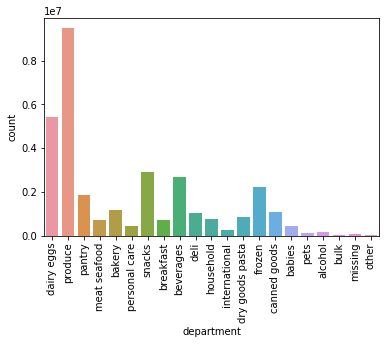

In [16]:
dep_count = sns.countplot(prior.department)
dep_count.set_xticklabels(dep_count.get_xticklabels(), rotation=90);

Looking at departments now, the most commonly purchased items are produce by far, followed by dairy and egg products. Snacks, beverages, frozen goods and pantry items seem to be the next most popular categories.

In [17]:
means = prior.groupby('department').mean()[['add_to_cart_order', 'reordered', 'order_dow', 'days_since_prior_order']]

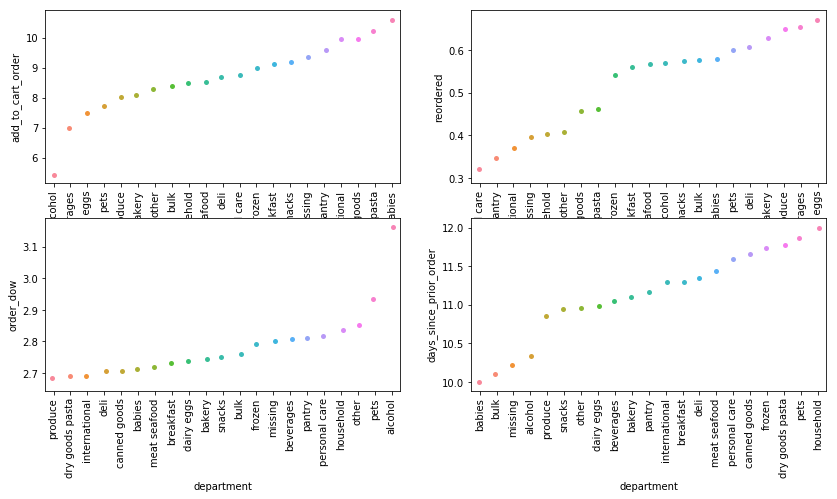

In [18]:
plt.figure(figsize=(14,7))
plt.subplot(221)
g = sns.stripplot(x=means.add_to_cart_order.sort_values().index, 
                  y=means.add_to_cart_order.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.subplot(222)
g = sns.stripplot(x=means.reordered.sort_values().index, 
                  y=means.reordered.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.subplot(223)
g = sns.stripplot(x=means.order_dow	.sort_values().index, 
                  y=means.order_dow	.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);
plt.subplot(224)
g = sns.stripplot(x=means.days_since_prior_order.sort_values().index, 
                  y=means.days_since_prior_order.sort_values())
g.set_xticklabels(g.get_xticklabels(), rotation=90);

Grouping by department offers more insight about the habits of purchasing different kind of products.

- Alcohol seems to often be one of the first items in the cart, probably meaning that users looking to purchase alcohol are focused on that goal. Alcohol unsurprisingly is morepopular on the weekends and is ordered frequently.

- On the other end, baby products tend to be last added to the cart, which can be a surprise, indicating people probably did not expect to find any baby products on the app and were probably on to buy something else. This could be a good target for promotions/recommendations especially since they seem to be the products needing the most frequent purchases.

- In terms of brand opinion, it seems that users purchasing eggs and beverages have strong opinions about brands and seem to reorder the same product frequently. 


In [19]:
del means

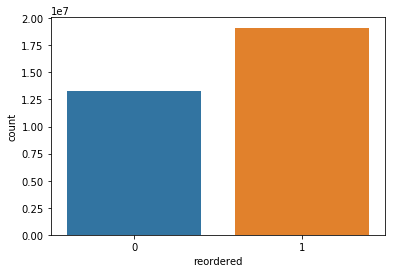

In [20]:
sns.countplot(prior.reordered);

An interesting metric for recommendations, reordered items seem to be more common then not. However, a good amount of products bought were never bought by that user before, thus a recommendation engine shoudl probably not focus only on previously purchased products.

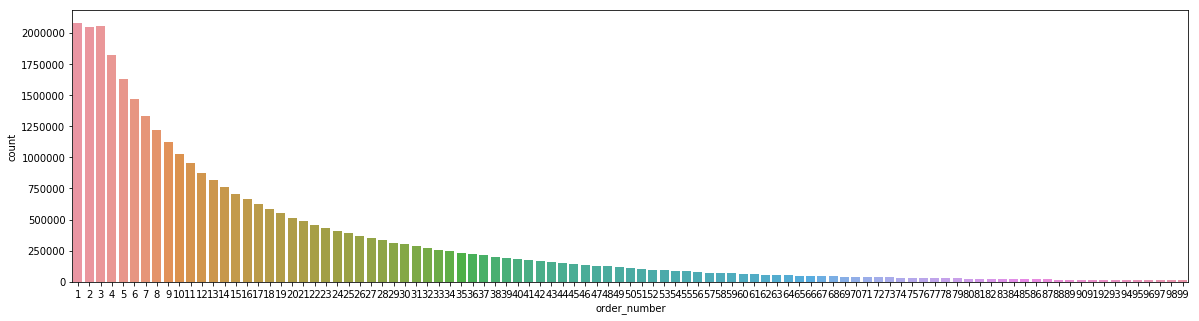

In [21]:
plt.figure(figsize=(20,5))
sns.countplot(prior.order_number);

Finally, looking at the number of orders, our data seems to heavily emphasize the first few orders made by customers. This makes sense looking at the number of users in the data but might be problematic by introducing some bias (user behaviour being less accurate for users with a higher number of previous orders).

# Feature generation

In [22]:
train = train.merge(right=orders, how='left', on='order_id')
test = test.merge(right=orders, how='left', on='order_id')

In [23]:
train.head(2)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,36,39612,1,0,79431,train,23,6,18,30.0
1,36,19660,2,1,79431,train,23,6,18,30.0


In [24]:
test.head(2)

,order_id,product_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,112108,test,4,4,10,9.0
1,1,11109,112108,test,4,4,10,9.0


These are the dataframes we will work with for model training and testing. However, we can generate features based on all the prior orders that can be traced back using product or user ids.

## User features

In [25]:
user_features = pd.concat([
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_number'].max().rename('user_total_orders'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['days_since_prior_order'].sum().rename('total_days_since'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['days_since_prior_order'].mean().rename('avg_days_since'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_dow'].mean().rename('avg_dow'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_dow'].apply(lambda x: stats.mode(x)[0][0]).rename('most_common_dow'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_hour_of_day'].mean().rename('avg_hour'),
    orders[orders.eval_set == 'prior'].groupby("user_id")['order_hour_of_day'].apply(lambda x: stats.mode(x)[0][0]).rename('most_common_hour'),
    prior.groupby("user_id")['product_id'].apply(set).rename('all_products')
], axis=1).reset_index()

In [26]:
user_features_2 = pd.concat([
    prior.groupby('user_id')['product_id'].count().rename('user_total_products'),
    prior.groupby('user_id')['product_id'].nunique().rename('user_distinct_products'),
], axis=1).reset_index()

In [27]:
user_features = pd.merge(user_features, user_features_2, on='user_id', how='left')
del user_features_2

In [28]:
user_features['avg_order_size'] = user_features.user_total_products/user_features.user_total_orders
user_features['avg_days_since'] = user_features.total_days_since/(user_features.user_total_orders - 1)
user_features['distinct_per_order'] = user_features.user_distinct_products/user_features.user_total_orders

In [29]:
user_features.head(1)

,user_id,user_total_orders,total_days_since,avg_days_since,avg_dow,most_common_dow,avg_hour,most_common_hour,all_products,user_total_products,user_distinct_products,avg_order_size,distinct_per_order
0,1,10,176.0,19.555555,2.5,1,10.3,7,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",59,18,5.9,1.8


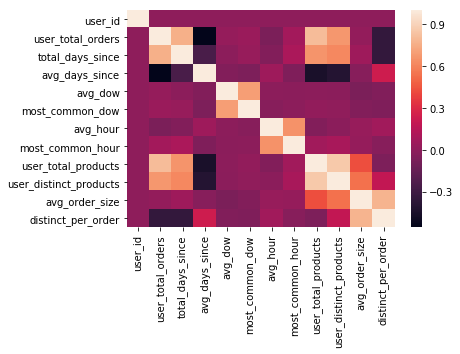

In [30]:
sns.heatmap(user_features.corr());

Some features seem highly correlated but we won't be using a model where that's an issue. Let's try to use some unsupervised learning to segment the users.

### Clustering

In [31]:
for k in range(2,11):
    minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=k,
    batch_size=20000,
    random_state=42
    )
    minibatchkmeans.fit(user_features.drop(['user_id', 'all_products'], axis=1))

    labels = minibatchkmeans.labels_
    print(k)
    print(metrics.silhouette_score(user_features.drop(['user_id', 'all_products'], axis=1), 
                                   labels, 
                                   metric='euclidean', 
                                   sample_size=10000,
                                   random_state=42))

2
0.6739354258524997
3
0.5546252113731074
4
0.4981817399421154
5
0.4148289611669523
6
0.38983036965379114
7
0.39226131132482434
8
0.3547241711233755
9
0.3648251517018756
10
0.35753495189064216


The silhouette scores are not great and indicate that we should really only use two clusters. But we want to reduce the number of users per cluster so we will go with 5.

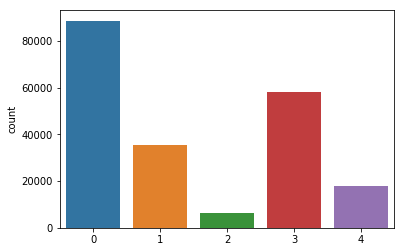

In [32]:
minibatchkmeans = MiniBatchKMeans(
    init='k-means++',
    n_clusters=5,
    batch_size=20000,
    random_state=41
    )

minibatchkmeans.fit(user_features.drop(['user_id', 'all_products'], axis=1))

y_pred = minibatchkmeans.predict(user_features.drop(['user_id', 'all_products'], axis=1))

sns.countplot(y_pred);

The five clusters don't seem balanced in terms ofpopulation but let's look at other properties for each of them.

In [33]:
user_features['user_group'] = y_pred

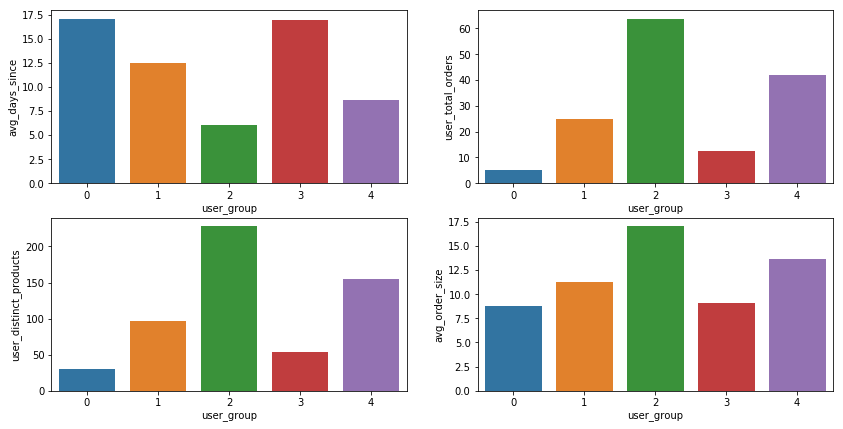

In [34]:
plt.figure(figsize=(14,7))
plt.subplot(221)
g = sns.barplot(x=user_features.groupby('user_group').mean().avg_days_since.index,
                y=user_features.groupby('user_group').mean().avg_days_since);
plt.subplot(222)
g = sns.barplot(x=user_features.groupby('user_group').mean().user_total_orders.index,
                y=user_features.groupby('user_group').mean().user_total_orders);
plt.subplot(223)
g = sns.barplot(x=user_features.groupby('user_group').mean().user_distinct_products.index,
                y=user_features.groupby('user_group').mean().user_distinct_products);
plt.subplot(224)
g = sns.barplot(x=user_features.groupby('user_group').mean().avg_order_size.index,
                y=user_features.groupby('user_group').mean().avg_order_size);

Interestingly, the smallest group, group 2, is made up of users who make a lot of large orders and frequently. They probably represent the bulk of the revenue for the app (loyal spenders). They could be a good target for advertisment or promotional offers (referral benefits for example).
The largest group, number 1, buys the same products each time but not very often. Exposing them to othe rthings might make them retunr more often or discover new products.

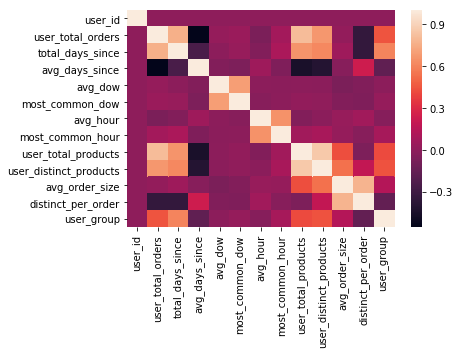

In [35]:
sns.heatmap(user_features.corr());

## Product features

In [36]:
product_features = pd.concat([
    prior.groupby("product_id")['order_id'].count().rename('product_total_orders'),
    prior.groupby("product_id")['add_to_cart_order'].mean().rename('avg_add_to_cart_order'),
    prior.groupby("product_id")['reordered'].sum().rename('total_product_reorders'),
    prior.groupby("product_id")['reordered'].mean().rename('avg_product_reorders'),
    prior.groupby("product_id")['order_dow'].mean().rename('prod_avg_dow'),
    prior.groupby("product_id")['days_since_prior_order'].mean().rename('prod_avg_days_since_prior'),
    prior.groupby("product_id")['order_hour_of_day'].mean().rename('prod_avg_hour')
], axis=1).reset_index()
del prior

In [37]:
product_features = pd.merge(product_features, products, on='product_id', how='right')

In [38]:
product_features.isna().sum()

product_id                    0
product_total_orders         11
avg_add_to_cart_order        11
total_product_reorders       11
avg_product_reorders         11
prod_avg_dow                 11
prod_avg_days_since_prior    42
prod_avg_hour                11
product_name                  0
aisle_id                      0
department_id                 0
dtype: int64

It seems like some products have never been ordered, which would be an issue when trying to predict if someone will buy them. We could just drop them but haing informations on aisle and department can still lead to a decent recommendation in some cases. So we will fill the missing data with the average observed.

In [39]:
### Fill the missing product information with the average observed, can take a while
product_features = product_features.fillna(product_features.mean())

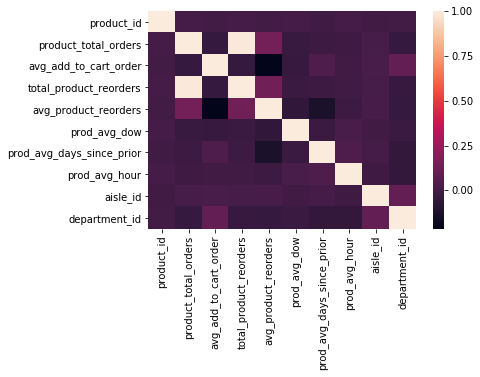

In [40]:
sns.heatmap(product_features.corr());

### Clustering

In [41]:
product_features_dummies = pd.get_dummies(product_features, columns=['department_id', 'aisle_id'])

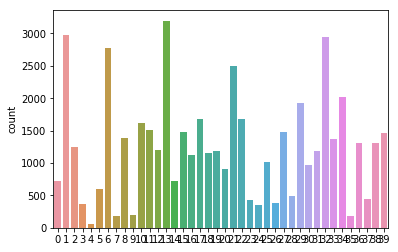

In [42]:
kmeans = KMeans(n_clusters=40,
                init='k-means++',
                precompute_distances='auto',
                random_state=41)

kmeans.fit(product_features_dummies.drop(['product_id', 'product_total_orders', 'avg_add_to_cart_order',
       'total_product_reorders', 'avg_product_reorders', 'prod_avg_dow', 'product_name'], axis=1))

y_pred = kmeans.predict(product_features_dummies.drop(['product_id', 'product_total_orders', 'avg_add_to_cart_order',
       'total_product_reorders', 'avg_product_reorders', 'prod_avg_dow', 'product_name'], axis=1))

sns.countplot(y_pred);

Using only some features we generate 40 different categories of products that can help draw relationships between products when trying tyo generate a recommendation.

In [43]:
product_features['product_group'] = y_pred

# Modeling

In [44]:
user_features.head(1)

,user_id,user_total_orders,total_days_since,avg_days_since,avg_dow,most_common_dow,avg_hour,most_common_hour,all_products,user_total_products,user_distinct_products,avg_order_size,distinct_per_order,user_group
0,1,10,176.0,19.555555,2.5,1,10.3,7,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",59,18,5.9,1.8,3


In [45]:
product_features.head(1)

,product_id,product_total_orders,avg_add_to_cart_order,total_product_reorders,avg_product_reorders,prod_avg_dow,prod_avg_days_since_prior,prod_avg_hour,product_name,aisle_id,department_id,product_group
0,1,1852.0,5.801836,1136.0,0.613391,2.776458,10.432725,13.238121,Chocolate Sandwich Cookies,61,19,29


These are the features we will use for our model (as well as the order details).

Let's try to make some predictions now !

## Predicting the size of an order

First, we try to predict the size of an order.

In [46]:
train_test = train.set_index(['order_id', 'product_id'],  drop=False)

In [47]:
### Creating the size feature we're going to try to predict
y_size = []
for ord in train_test.order_id.unique():
    y_size.append(len(train_test.loc[ord].index))

In [48]:
size = pd.DataFrame({'size':y_size, 'order_id':train_test.order_id.unique()})
del y_size
del train_test

In [49]:
orders = pd.merge(orders, size, on='order_id', how='left')
del size

In [50]:
X_train_size = orders[orders.eval_set=='train'].drop(columns=['order_id', 'eval_set'])
X_train_size = pd.merge(X_train_size, user_features, on='user_id', how='left')

In [51]:
y_train_size = X_train_size['size']
X_train_size = X_train_size.drop(columns=['user_id', 'size', 'all_products'])

In [52]:
X_train_size, X_test_size, y_train_size, y_test_size = train_test_split(X_train_size,
                                                                        y_train_size,
                                                                        test_size=0.2,
                                                                        random_state=42 )

Now that we have our train and test sets we try to fit a random forest classifier.

In [53]:
rfc = ensemble.RandomForestClassifier(n_estimators=100,
                                      criterion='entropy',
                                      max_depth=10)

In [54]:
rfc.fit(X_train_size, y_train_size)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [55]:
y_pred_size = rfc.predict(X_test_size)

In [56]:
accuracy_score(y_pred_size, y_test_size)

0.10796667005385631

In [57]:
(y_pred_size/y_test_size).mean()

1.1541576008781407

Our model seems to have bad accuracy, but is accuracy a good metric ? Predicting 9 products instead of 8 is better than 20 instead of 8. Looking from that perspective, it seems that on average we predict an 15% bigger order than the actual size which shouldnt be an issue if we use our model as a first pass to decide how many recommendations we want to give.

## Giving a list of recommended products

We will try to fit a gradient boosted tree to our data to try and predict what products belong to an order or not.

### Train and test functions

In [58]:
def train_xgb(train_data):
    
    """
    Trains a gradient boosted tree method on train data.

    Args:
        train_data: Dataframe containing user, product and order features 
                    as well as an 'in_order' column that indicates if the 
                    product is in that order.

    Returns:
        bst: trained gradient boosted tree method
        X_train: train split used for columns consistency when using 
                 bst.predict
    """

    X_train, X_val, y_train, y_val = train_test_split(train_data.drop(['order_id', 'product_id', 'add_to_cart_order',
                                                                        'reordered', 'user_id', 'eval_set','all_products',
                                                                        'prod_id_rand', 'in_order', 'product_name',
                                                                        'aisle_id', 'size'], axis=1), 
                                                          train_data.in_order,
                                                          test_size=0.2, random_state=42)
    
    d_train = xgboost.DMatrix(X_train, y_train)
    xgb_params = {
        "objective"         : "reg:logistic"
        ,"eval_metric"      : "logloss"
        ,"eta"              : 0.1
        ,"max_depth"        : 6
        ,"min_child_weight" : 10
        ,"gamma"            : 0.70
        ,"subsample"        : 0.76
        ,"colsample_bytree" : 0.95
        ,"alpha"            : 2e-05
        ,"lambda"           : 10
    }

    watchlist= [(d_train, "train")]
    bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=50, evals=watchlist, verbose_eval=10)
    xgboost.plot_importance(bst);
    
    d_val = xgboost.DMatrix(X_val)
    y_val_predict = (bst.predict(d_val) > 0.5).astype(int)
    
    print('Accuracy score : {}'.format(accuracy_score(y_val_predict, y_val)))
    print('F1 score : {}'.format(f1_score(y_val_predict, y_val)))
    
    return X_train, bst;

In [59]:
def predict_products(bst, X_train, test_orders, k, product_features, threshold):
    
    """
    Predicts what products are in an order

    Args:
        bst: a trained model for prediction
        X_train: Dataframe used for its columns order
        test_orders: Datframe with the orders features 
                     to make prediction on 
        k: (int) number of orders to predict from test orders
        product_features: Dataframe with product features
        threshold: float, 0 < threshold <1, cutoff to pick which 
                   products are in order

    Returns:
        results: Dataframe with order_id as column names and 
                 product_id as index, value of 0 if not predicted 
                 in order, 1 if predicted in order
    """
    
    results = pd.DataFrame(index=products.index)
    start_time = time.time()
    start_time_total = time.time()
    for i, order in enumerate(test_orders.order_id.unique()[:k]):
        prod_features = product_features.copy()
        prod_features['order_id'] = order
        prod_features = pd.merge(prod_features, 
                                 test_orders.drop_duplicates(subset=['order_id']), 
                                 on='order_id', how='left')

        X_test = prod_features.drop(['product_id', 'product_name', 'aisle_id', 'order_id'], axis=1)
        X_test = X_test[X_train.columns]
    
        d_test = xgboost.DMatrix(X_test)
        bst.predict(d_test)
    
        y_test_predict = (bst.predict(d_test) > threshold).astype(int)
        results = results.join(pd.DataFrame(y_test_predict, columns=[order]))
    
        if (i+1) % 10 == 0:
            iter_time = time.time() - start_time
            print('{} orders, done in {} seconds'.format(i+1,iter_time))
            start_time = time.time()
        
    total_time = time.time() - start_time_total
    print('Total time elapsed : {} seconds'.format(total_time))
    
    return results

### Creating train and test sets

#### Merge order and user features to train and test set

In [60]:
train_set = pd.merge(train, orders, 
                     on=['order_id','user_id', 'eval_set','order_number',
                         'order_dow','order_hour_of_day','days_since_prior_order'], 
                     how='left')

In [61]:
train_set = pd.merge(train_set, user_features, on='user_id', how='left')

In [62]:
test_set = pd.merge(test, orders, 
                    on=['order_id','user_id', 'eval_set','order_number',
                        'order_dow','order_hour_of_day','days_since_prior_order'], 
                    how='left')
del orders

In [63]:
test_set = pd.merge(test_set, user_features, on='user_id', how='left')

#### Generate random product_ids

The train data comes from the train orders, which we have approximately a million of.
We will train our model on this by changing half of the orders, modifying the product purchased to a random one.
This way, half our data is consistent and teh model should detect that and decide that this product is actually in that order, while when detecting a 'fake' product, it shouldn't fit and thus should output a zero.

In [64]:
### Generating the random product ids
prod_rand = np.random.randint(1,len(products)+1, size=(len(train_set)))
train_set['prod_id_rand'] = prod_rand
del prod_rand

In [65]:
train_half_index = train_set.head(len(train_set)//2).index

In [66]:
train_set.loc[train_half_index, 'product_id'] = train_set.iloc[train_half_index]['prod_id_rand']
train_set['in_order'] = 1 # Setting the 'in_order' feature to 1 everywhere, this is waht will be predicted
train_set.loc[train_half_index, 'in_order'] = 0 # Setting the feature to 0 when we have a random product in place

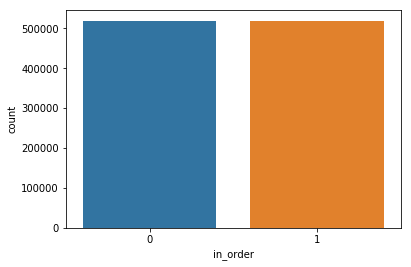

In [67]:
sns.countplot(train_set.in_order);

In [68]:
train_set = pd.merge(train_set, product_features, on='product_id', how='left')

In [69]:
test_for_pred = test_set.drop(['product_id', 'user_id', 
                               'eval_set', 'all_products'], axis=1)

### Train model and predict orders

C:\Users\Val\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-logloss:0.637892
[10]	train-logloss:0.402328
[20]	train-logloss:0.349864
[30]	train-logloss:0.33654
[40]	train-logloss:0.332674
[49]	train-logloss:0.33091
Accuracy score : 0.8562514744611296
F1 score : 0.8557946340167596


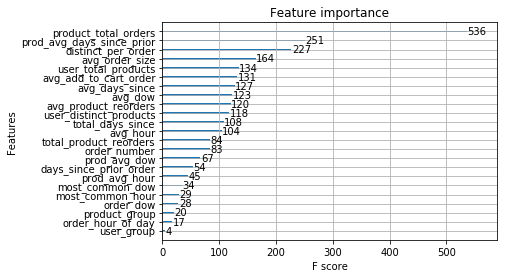

In [70]:
X_train, bst = train_xgb(train_set.drop(['department_id'], axis=1))

In [71]:
results = predict_products(bst, X_train, test_for_pred, 100, product_features.drop(['department_id'], axis=1), 0.99)

10 orders, done in 2.5844058990478516 seconds
20 orders, done in 2.1688950061798096 seconds
30 orders, done in 2.1759660243988037 seconds
40 orders, done in 2.1662514209747314 seconds
50 orders, done in 2.16692852973938 seconds
60 orders, done in 2.2034387588500977 seconds
70 orders, done in 2.191711902618408 seconds
80 orders, done in 2.170156240463257 seconds
90 orders, done in 2.1894419193267822 seconds
100 orders, done in 2.181279182434082 seconds
Total time elapsed : 22.198474884033203 seconds


We have a decent logloss to stop our model on with decent acccuracy and F1 scores.
The feature importance is interesting, seemingly valuing popular products, distinct products frequency and shopping frequency.

The model is also decently fast, taking 22 seconds for 100 orders (we have a total of around 32k orders in the test set so it would take approximately 2 hours to predict all of them.

Let's look at a predicted order now.

In [72]:
products['selected'] = results[1]

In [73]:
### Getting the products actually in the order
products[(products.product_id==49302) | (products.product_id==11109) | (products.product_id==10246) |
        (products.product_id==49683) | (products.product_id==43633) |(products.product_id==13176) |
        (products.product_id==47209) |(products.product_id==22035)][['product_name', 'aisle_id', 'department_id']]

,product_name,aisle_id,department_id
10245,Organic Celery Hearts,83,4
11108,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
13175,Bag of Organic Bananas,24,4
22034,Organic Whole String Cheese,21,16
43632,Lightly Smoked Sardines in Olive Oil,95,15
47208,Organic Hass Avocado,24,4
49301,Bulgarian Yogurt,120,16
49682,Cucumber Kirby,83,4


In [74]:
### Getting the recommended products
products[products.selected==1]

,product_id,product_name,aisle_id,department_id,selected
4917,4918,Pure & Free™ Baby Sunblock Sunscreen Lotion SP...,73,11,1
8514,8515,Organix Butcher & Bushel Grain-Gree Turkey & C...,40,8,1
13172,13173,Beef Ramen Noodle Soup,69,15,1
16793,16794,Compleats Microwavable Meal Chicken & Rice,4,9,1
21133,21134,Cream Top Apricot Mango Fruit on the Bottom Yo...,120,16,1
21899,21900,Alive! Children's Chewable Multivitamin Natura...,47,11,1
24848,24849,Cheese & Fresh Herb Flatbread Pizza,79,1,1
26204,26205,California Pinot Grigio,62,5,1
27839,27840,Icelandic White Ale 6 Pack,27,5,1
27960,27961,Mentho Lyptus Cough Suppressant Oral Anestheti...,11,11,1


We do not have any hit, but the recommendation engine should not realle be evaluated on this, since we are trying to give recommendations, we should go through the predictions manually and look how plausible a recommendation was compared to the actual order.

Here, it seems we are recommending a fruit yogurt to someone who came in to buy yogurt and produce which is not bad !

### With dummies for department_id

This time we use the department id as part of the features, we can try this since the previous model did not seem overly slow.

In [75]:
train_set_with_dummies = pd.get_dummies(train_set, columns=['department_id'])

[0]	train-logloss:0.63787
[10]	train-logloss:0.402212
[20]	train-logloss:0.350538
[30]	train-logloss:0.336435
[40]	train-logloss:0.332364
[49]	train-logloss:0.330522
Accuracy score : 0.8561648122559616
F1 score : 0.8556142496049025


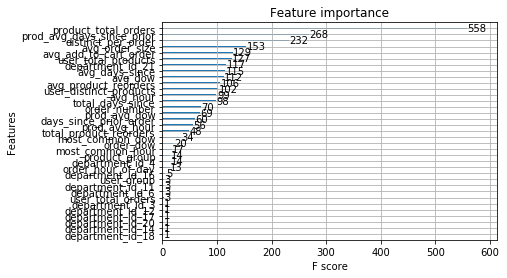

In [76]:
X_train_dummies, bst_dummies = train_xgb(train_set_with_dummies)

This time it seems that some departments play a role in the final prediction.

In [77]:
product_features_with_dummies = pd.get_dummies(product_features, columns=['department_id'])

In [79]:
results_dummies = predict_products(bst_dummies, X_train_dummies, test_for_pred, 100, product_features_with_dummies, 0.99)

10 orders, done in 2.6875264644622803 seconds
20 orders, done in 2.6428284645080566 seconds
30 orders, done in 2.6823933124542236 seconds
40 orders, done in 2.6818344593048096 seconds
50 orders, done in 2.715777635574341 seconds
60 orders, done in 2.6460154056549072 seconds
70 orders, done in 2.629012107849121 seconds
80 orders, done in 2.750382661819458 seconds
90 orders, done in 2.7158453464508057 seconds
100 orders, done in 2.701449155807495 seconds
Total time elapsed : 26.853065013885498 seconds


The model is still relatively fast, taking approximately  27 seconds for 100 orders, which would be around two and a half hours for all orders.

In [81]:
results_dummies.sum().mean()

12.54

Recommending an average of 12.5 products per order seems like a good number for a recommendation engine.

In [82]:
products['selected'] = results_dummies[1]

In [83]:
products[products.selected==1]

,product_id,product_name,aisle_id,department_id,selected
13172,13173,Beef Ramen Noodle Soup,69,15,1
16793,16794,Compleats Microwavable Meal Chicken & Rice,4,9,1
21133,21134,Cream Top Apricot Mango Fruit on the Bottom Yo...,120,16,1
21899,21900,Alive! Children's Chewable Multivitamin Natura...,47,11,1
24848,24849,Cheese & Fresh Herb Flatbread Pizza,79,1,1
26204,26205,California Pinot Grigio,62,5,1
27839,27840,Icelandic White Ale 6 Pack,27,5,1
27960,27961,Mentho Lyptus Cough Suppressant Oral Anestheti...,11,11,1
47198,47199,Rotelle,131,9,1
47615,47616,Sesame Street Organic Mini Blueberry Pancakes,52,1,1


The predictions for this order seem pretty similar. We would need to look into more orders to see if the model behaves differently in other cases.

The best way to measure how good our model is would be to conduct A/B testing on customers and track their conversion rate.

After that we could make improvements to the model.

This is a crude attempt at trying to make recommendations running everything locally. Better results could be achieved using cloud computing and more complex and ressource consuming methods.